Import libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch

Exercise 1.1

In [22]:
class LQRProblem:
    def __init__(self, H, M, C, D, R, sigma, T):
        """
        Initializes the LQR problem with the given matrices and time horizon T.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.S_solution, self.time_solution = None, None  # Will be set after solving Riccati ODE
    
    def riccati_ode(self, t, S_flat, H, M, D_inv, C):
        """
        Defines the Riccati differential equation.
        """
        S = S_flat.reshape(2, 2)
        dSdt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
        return dSdt.flatten()
    
    def solve_riccati_ode(self, time_grid, atol=1e-10, rtol=1e-10):
        """
        Solves the Riccati ODE on the given time grid using scipy's solve_ivp.
        """
        D_inv = np.linalg.inv(self.D)
        S0_flat = self.R.flatten()
        sol = solve_ivp(
            self.riccati_ode, 
            [self.T, time_grid[0]], 
            S0_flat, 
            t_eval=time_grid[::-1], 
            args=(self.H, self.M, D_inv, self.C), 
            atol=atol, 
            rtol=rtol,
            method='Radau'  # This is a common choice for stiff ODEs
        )
        self.S_solution = sol.y.reshape(2, 2, len(time_grid))[:, :, ::-1]
        self.time_solution = sol.t[::-1]
        return self.S_solution, self.time_solution


    def compute_value_function(self, t_tensor, x_tensor):
        """
        Computes the control problem value v(t, x) for a batch of space x using the solution of S
        and includes the integral term.
        """
       
        batch_size = x_tensor.shape[0]
        
        # Convert all relevant data to PyTorch tensors
        sigma_tensor = torch.tensor(self.sigma, dtype=torch.float32)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float32)
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float32)
        dt = solution_time[1] - solution_time[0]
        
        sigma_squared = sigma_tensor @ sigma_tensor.T
        
        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float32), dim=1)
        
        # Initialize v
        v = torch.zeros(batch_size, 1, dtype=torch.float32)
        
        # Pre-compute trace values for each S_tensor slice, to be used in batch operations
        trace_values = torch.einsum('ij,jik->k', sigma_squared, S_tensor)
        
        # Compute the cumulative sum of trace values for integral computation
        cum_integral = torch.cumsum(trace_values, dim=0) * dt
        
        # Adjust cum_integral by subtracting the cumulative sum up to each t, to effectively start from each t
        adjusted_integral = cum_integral[-1] - cum_integral
        
        for i in range(batch_size):
            idx = time_indexes[i]
            
            # Calculate the integral from t to T
            integral_term = adjusted_integral[idx]
            
            # Calculate v for each batch
            S_at_t = S_tensor[:, :, idx]
            v[i] = x_tensor[i].T @ S_at_t @ x_tensor[i] + integral_term

        return v

    def compute_markov_control(self, t_tensor, x_tensor):
        """
        Computes the Markov control function for a batch of x at time t using S(t).
        """
        batch_size = x_tensor.shape[0]

        # Find the index corresponding to the nearest time point in the time grid
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float32)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float32)

        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float32), dim=1)

        # Initialize control
        control = torch.zeros(batch_size, 2, dtype=torch.float32)

        D_inv = torch.tensor(np.linalg.inv(self.D), dtype=torch.float32)
        M_T = torch.tensor(self.M.T, dtype=torch.float32)

        # Compute the control using S(t)
        for i in range(batch_size):
            S_t = S_tensor[:, :, time_indexes[i]]

            control[i] = - D_inv @ M_T @ S_t @ x_tensor[i].T  # Make sure the dimensions are correct

        return control

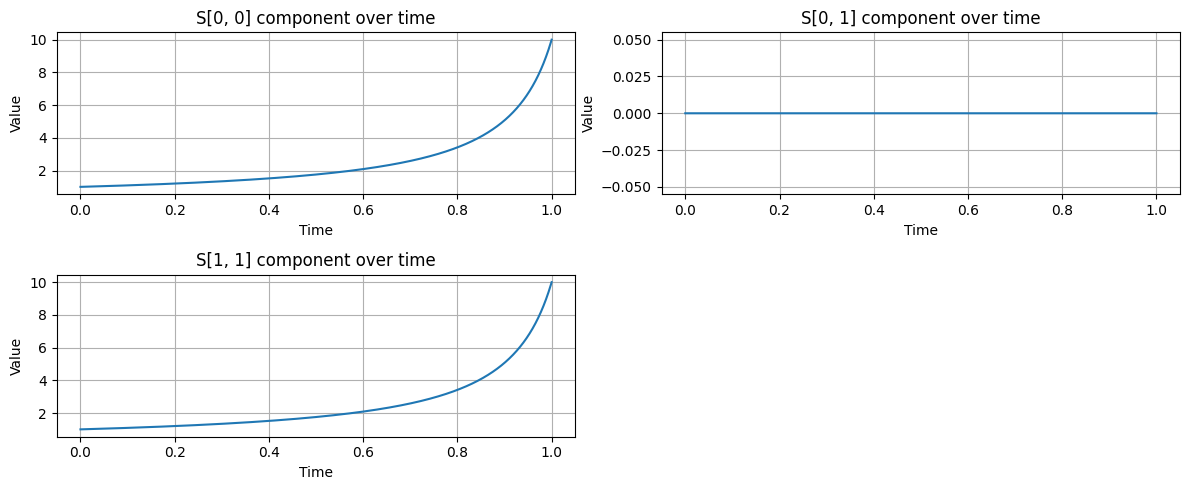

In [52]:
# Example matrices (to be replaced with actual problem data)
H = np.array([[1, 0], [0, 1]]) * 0.1
M = np.array([[1, 0], [0, 1]])
sigma = np.array([[1, 0], [0, 1]]) * 0#0.001
C = np.array([[0, 0], [0, 0]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[1, 0], [0, 1]]) * 10
T = 1

# Time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)

# Example of using the class (with random time and space inputs for demonstration)
torch.manual_seed(0)  # For reproducibility
random_t = torch.rand(5) * T
random_x = torch.rand(5, 2) * 6 - 3  # Uniformly sampled from [-3, 3]

# Initialize the LQR problem
lqr_problem = LQRProblem(H, M, C, D, R, sigma, T)
S_solution, time_solution = lqr_problem.solve_riccati_ode(time_grid)

plt.figure(figsize=(12, 5))

# Plot for S[0, 0]
plt.subplot(2, 2, 1)
plt.plot(time_solution, S_solution[0, 0, :], label='S[0, 0]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('S[0, 0] component over time')
plt.grid(True)

# Plot for S[0, 1]
plt.subplot(2, 2, 2)
plt.plot(time_solution, S_solution[0, 1, :], label='S[0, 1]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('S[0, 1] component over time')
plt.grid(True)

# Since S is symmetric, S[1, 0] should be the same as S[0, 1]
# Plot for S[1, 1]
plt.subplot(2, 2, 3)
plt.plot(time_solution, S_solution[1, 1, :], label='S[1, 1]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('S[1, 1] component over time')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

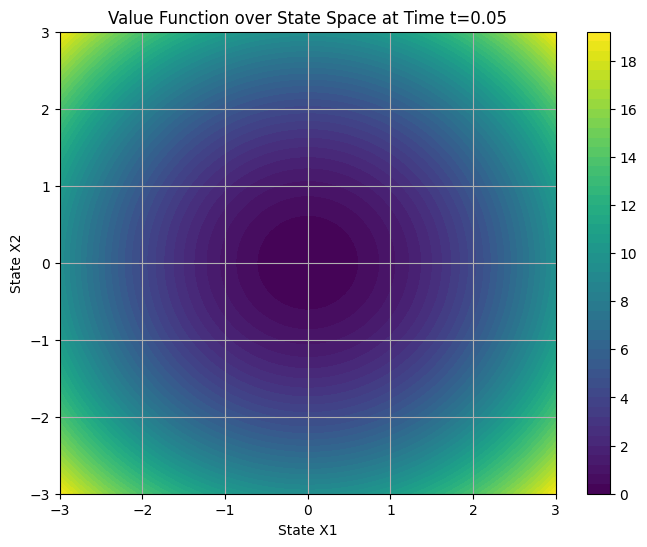

In [53]:
# Solve the Riccati ODE using the given time grid
lqr_problem.solve_riccati_ode(time_grid)

# Assuming T and lqr_problem are already defined
t = T/20
T_tensor = torch.tensor([t], dtype=torch.float32)  # Convert T to a tensor

# Generate a grid of state space points to compute the value function
state_space_grid = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(state_space_grid, state_space_grid)
value_function_values = np.zeros_like(X1)

# Compute the value function for each point in the state space grid at time T
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = torch.tensor([[X1[i, j], X2[i, j]]], dtype=torch.float32)  # Shape: [1, 2]
        val = lqr_problem.compute_value_function(T_tensor, x).item()  # Use T_tensor
        value_function_values[i, j] = val

# Plotting the value function
plt.figure(figsize=(8, 6))
cp = plt.contourf(X1, X2, value_function_values, cmap='viridis', levels=50)
plt.colorbar(cp)
plt.xlabel('State X1')
plt.ylabel('State X2')
plt.title(f'Value Function over State Space at Time t={t}')
plt.grid(True)
plt.show()

In [54]:
random_t = torch.rand(5) * T
random_x = torch.rand(5, 2) * 6 - 3 
value = lqr_problem.compute_value_function(random_t, random_x)
control = lqr_problem.compute_markov_control(random_t, random_x)

print(value)
print(control)

tensor([[13.4468],
        [13.9893],
        [ 1.1456],
        [17.6510],
        [ 5.4871]])
tensor([[-1.9818, -4.5309],
        [ 1.5933, -5.7933],
        [ 1.6557, -1.0869],
        [-3.1703,  3.2480],
        [ 2.5009,  1.0057]])


Exercise 1.2

In [55]:
def simulate_dynamics(lqr_problem, t0, x0, N_steps, num_samples):
    dt = lqr_problem.T / N_steps
    final_costs = []
    
    # Convert system matrices to tensors, including D_inv_MT
    H_tensor = torch.tensor(lqr_problem.H, dtype=torch.float32)
    M_tensor = torch.tensor(lqr_problem.M, dtype=torch.float32)
    sigma_tensor = torch.tensor(lqr_problem.sigma, dtype=torch.float32)
    D_inv_MT_tensor = torch.tensor(np.linalg.inv(lqr_problem.D) @ lqr_problem.M.T, dtype=torch.float32)  # Now a tensor
    S_tensor = torch.tensor(lqr_problem.S_solution.copy(), dtype=torch.float32)
    solution_time = torch.tensor(lqr_problem.time_solution.copy(), dtype=torch.float32)
    x = x0.clone().detach()
    C_tensor = torch.tensor(lqr_problem.C, dtype=torch.float32)
    D_tensor = torch.tensor(lqr_problem.D, dtype=torch.float32)

    time_index = torch.argmax((t0 <= solution_time).float()).item()

    for _ in range(num_samples): 
        cost = 0.0
        for step in range(time_index, N_steps):
            # t = t0 + step*dt #lqr_problem.T - step * dt
            # Updated to ensure control computation uses tensor operations
            S_t = S_tensor[:, :, step] #S_tensor[:, :, -(step+1)]
            control = -(D_inv_MT_tensor @ S_t @ x).squeeze()
            
            dx = H_tensor @ x + M_tensor @ control
            dW = torch.randn(2, dtype=torch.float32) * torch.sqrt(torch.tensor(dt))
            # single_random = torch.randn(1, dtype=torch.float32) * torch.sqrt(torch.tensor(dt))
            # dW = single_random.repeat(2)  # Repeat the single random value twice to get a 2-element tensor
            x += dx * dt + sigma_tensor @ dW
            
            cost += (x.T @ C_tensor @ x + control.T @ D_tensor @ control) * dt
            
        cost += x.T @ torch.tensor(lqr_problem.R, dtype=torch.float32) @ x
        final_costs.append(cost.item())
    
    return final_costs

def compute_error(final_costs, theoretical_value):
    mse = (final_costs - theoretical_value)**2
    return mse

In [56]:
print(np.average(final_costs))
print(theoretical_value)

0.008765815142493636
2.2046637535095215


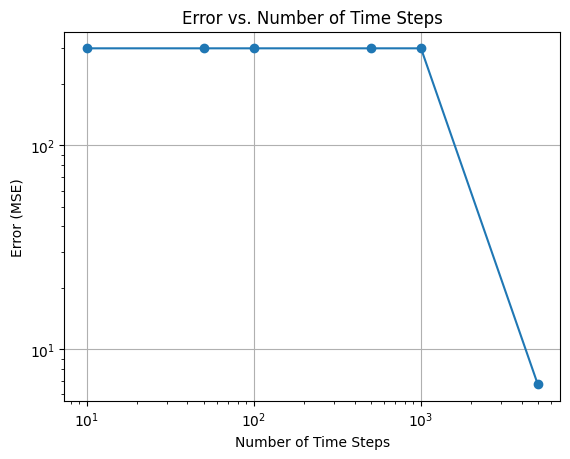

In [59]:
# Example usage:
t0 = torch.tensor([0.3], dtype=torch.float32)
x0 = torch.tensor([1.0, 1.0])  # Initial state

# Number of time steps and Monte Carlo samples for the simulation
N_steps_list = [10, 50, 100, 500, 1000, 5000]
num_samples = 100 #000

# Generate a time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)  # Fine time grid for better accuracy
lqr_problem.solve_riccati_ode(time_grid)

# Compute the theoretical value at the initial state x0
theoretical_value = lqr_problem.compute_value_function(t0, x0.unsqueeze(0)).item()

# Run the simulation and compute errors for different numbers of time steps
errors = []
for N_steps in N_steps_list:
    final_costs = simulate_dynamics(lqr_problem, t0, x0, N_steps, num_samples)
    
    error = compute_error(np.average(final_costs), theoretical_value)
    errors.append(error)

# Plot the error vs. number of time steps
plt.loglog(N_steps_list, errors, marker='o')
plt.xlabel('Number of Time Steps')
plt.ylabel('Error (MSE)')
plt.title('Error vs. Number of Time Steps')
plt.grid(True)
plt.show()


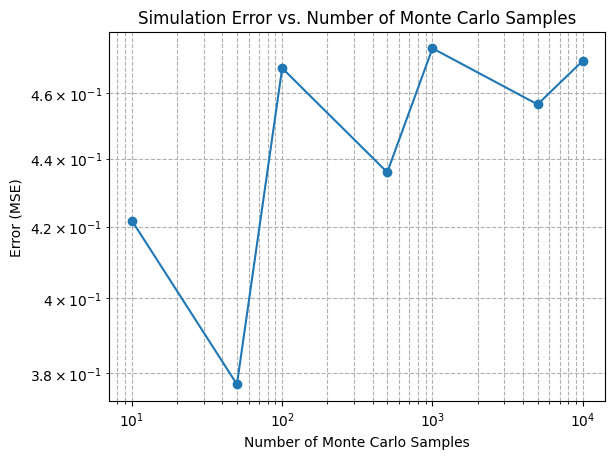

In [ ]:
# Step 1: Fix a large number of time steps
N_steps_fixed = 5000

# Step 2: Use the previously defined simulate_dynamics function, no changes needed here

# Step 3: Vary the number of Monte Carlo samples and compute errors
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000]
errors = []

for num_samples in num_samples_list:
    final_costs = simulate_dynamics(lqr_problem, x0, N_steps_fixed, num_samples)
    error = compute_error(final_costs, theoretical_value)
    errors.append(error)

# Step 4: Plot the error on a log-log plot
plt.loglog(num_samples_list, errors, marker='o', linestyle='-')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('Error (MSE)')
plt.title('Simulation Error vs. Number of Monte Carlo Samples')
plt.grid(True, which="both", ls="--")
plt.show()


In [ ]:
# Parameters
T = 1.0  # total time
N = 1000  # number of time steps
dt = T/N  # time step size
M_paths = 100  # number of Monte Carlo paths

# Precompute constants
MD_inv = M @ np.linalg.inv(D)
MD_inv_MT = MD_inv @ M.T

# Initialize the paths
X_paths = np.zeros((M_paths, 2, N+1))  # Adjusted for 2x1 X

# Initial condition for X(t)
X0 = np.array([1, 1])  # 2x1 vector
integral_values = np.zeros(M_paths)

time_grid = np.linspace(0, T, N)
S_solution, time_solution = lqr_problem.solve_riccati_ode(time_grid)

for path in range(M_paths):
    X = X0.copy()
    integral = 0
    for t in range(N):
        dW = np.random.normal(0, 1, (2, 1)) * np.sqrt(dt)
        dX = (H @ X - MD_inv_MT @ S @ X) * dt + sigma @ dW
        X_next = X + dX
        term1 = X.T @ C @ X
        # I still need to find the proper S here for this timestep
        term2 = (MD_inv_MT @ S @ X).T @ D @ (MD_inv_MT @ S @ X)
        integral += (term1 + term2) * dt
        X = X_next
    final_term = X.T @ R @ X
    integral_values[path] = integral + final_term

# Calculate the mean of the integrals
mean_integral = np.mean(integral_values)


NameError: name 'S' is not defined

Exercise 2.1

Epoch [100/500], Loss: 1143.0962
Epoch [200/500], Loss: 645.2738
Epoch [300/500], Loss: 279.1406
Epoch [400/500], Loss: 163.7263
Epoch [500/500], Loss: 142.0038


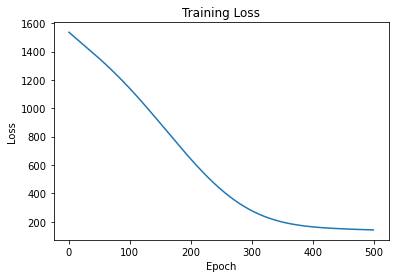

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class ValueFunctionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueFunctionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer to hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden layer to output layer
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # Activation function applied to the hidden layer
        x = self.fc2(x)  # Output layer
        return x

# Assuming the LQRProblem class and an instance 'lqr_problem' is defined as above

# Generate training data
num_samples = 1000  # Number of samples for training data
state_space = torch.rand(num_samples, 2) * 6 - 3  # State space sampled uniformly between [-3, 3]
value_function_data = lqr_problem.compute_value_function(state_space)

# Neural network setup
input_size = 2  # State space dimension
hidden_size = 100  # Number of neurons in the hidden layer
output_size = 1  # Value function is a scalar

# Instantiate the neural network
value_network = ValueFunctionNN(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(value_network.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 500  # Number of epochs for training
training_losses = []

for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = value_network(state_space.float())

    # Calculate loss: softmax --> cross entropy loss
    loss = criterion(outputs, value_function_data.float())

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    # Record and print the training loss
    training_losses.append(loss.item())

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, you can save the model if you want to use it later
# torch.save(value_network.state_dict(), 'value_network_model.pth')

# After training, plot the training loss
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Exercise 2.2

Epoch [100/500], Control Loss: 0.0328
Epoch [200/500], Control Loss: 0.0104
Epoch [300/500], Control Loss: 0.0031
Epoch [400/500], Control Loss: 0.0014
Epoch [500/500], Control Loss: 0.0010


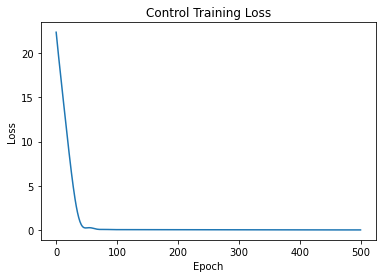

In [ ]:
# Define the neural network architecture for the Markov control function
class MarkovControlNN(nn.Module):
    def __init__(self):
        super(MarkovControlNN, self).__init__()
        self.fc1 = nn.Linear(2, 100)  # Input layer to first hidden layer with 100 neurons
        self.fc2 = nn.Linear(100, 100)  # Second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 2)  # Output layer with 2 neurons
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = self.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = self.fc3(x)  # Output layer
        return x

# Assuming the LQRProblem class and an instance 'lqr_problem' is defined as above

# Generate training data for Markov control
control_targets = lqr_problem.compute_markov_control(state_space)

# Instantiate the neural network for Markov control
control_network = MarkovControlNN()

# Loss function and optimizer for the control network
control_criterion = nn.MSELoss()  # Mean squared error loss
control_optimizer = optim.Adam(control_network.parameters(), lr=0.001)  # Adam optimizer

# Training loop for the control network
control_training_losses = []

for epoch in range(num_epochs):
    # Zero the parameter gradients
    control_optimizer.zero_grad()

    # Forward pass to get output/logits
    control_outputs = control_network(state_space.float())

    # Calculate loss
    control_loss = control_criterion(control_outputs, control_targets.float())

    # Getting gradients w.r.t. parameters
    control_loss.backward()

    # Updating parameters
    control_optimizer.step()

    # Record the training loss
    control_training_losses.append(control_loss.item())

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Control Loss: {control_loss.item():.4f}')

# After training, plot the training loss for the control network
plt.plot(control_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Control Training Loss')
plt.show()


Exercise 3.1

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming H, M, C, D, R, sigma are defined
# For the sake of this example, dummy definitions are provided
H = torch.tensor([[1.0, 0], [0, 1.0]])
M = torch.tensor([[1.0, 0], [0, 1.0]])
C = torch.tensor([[1.0, 0], [0, 1.0]])
D = torch.tensor([[1.0, 0], [0, 1.0]])
R = torch.tensor([[1.0, 0], [0, 1.0]])
sigma = torch.tensor([[1.0, 0], [0, 1.0]])
alpha = torch.tensor([1.0, 1.0])

class LinearPDE(nn.Module):
    def __init__(self, net, T):
        super(LinearPDE, self).__init__()
        self.net = net
        self.T = T

    def equation(self, t, x):
        """
        The PDE equation to be minimized
        """
        # Assuming t and x are Variables with requires_grad=True
        u = self.net(torch.cat((t, x), dim=1))
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        term1 = 0.5 * torch.sum(sigma @ sigma.T * u_xx, dim=1, keepdim=True)
        term2 = u_x @ H @ x.T + u_x @ M @ alpha
        term3 = x @ C @ x.T + alpha.T @ D @ alpha
        pde_res = u_t + term1 + term2 + term3

        return pde_res

    def boundary_condition(self, x):
        """
        Boundary condition u(T, x) = x^T R x
        """
        target = x @ R @ x.T
        u = self.net(torch.cat((torch.ones(x.size(0), 1) * self.T, x), dim=1))
        return (u - target) ** 2

    def loss(self, t_batch, x_batch):
        pde_loss = torch.mean(self.equation(t_batch, x_batch) ** 2)
        boundary_loss = torch.mean(self.boundary_condition(x_batch))
        return pde_loss + boundary_loss

# Define the network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

net = Net(3, 50, 1)  # Adjust the input_size and hidden_size accordingly
model = LinearPDE(net, T=1.0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

# Assuming Net and LinearPDE classes are defined as before

def monte_carlo_solution(t, x):
    # Placeholder for your Monte Carlo solution adapted from Exercise 1.2
    # Replace this with the actual computation
    # For example:
    return np.sin(t) + np.cos(np.linalg.norm(x, axis=1))

# Initialize the model
net = Net(3, 50, 1)  # Adjust as needed
T = 1
model = LinearPDE(net, T)

# Training setup
epochs = 1000
learning_rate = 0.001
batch_size = 64
print_interval = 100

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    t_batch = torch.rand(batch_size, 1) * T
    x_batch = torch.rand(batch_size, 2)  # Adjust as needed
    
    t_batch.requires_grad_(True)
    x_batch.requires_grad_(True)
    
    loss = model.loss(t_batch, x_batch)
    loss.backward()
    optimizer.step()
    
    if epoch % print_interval == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_history.append(loss.item())

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_history)) * print_interval, loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Error against Monte Carlo solution
# Sampling points for comparison
t_val = torch.rand(100, 1) * T
x_val = torch.rand(100, 2)  # Adjust as needed

with torch.no_grad():
    net_solution = model.net(torch.cat((t_val, x_val), dim=1)).numpy().flatten()

# Compute Monte Carlo solution for the same points
t_val_np = t_val.numpy().flatten()
x_val_np = x_val.numpy()
mc_solution = monte_carlo_solution(t_val_np, x_val_np)

# Compute error
error = np.abs(net_solution - mc_solution)

# Plot error comparison
plt.figure(figsize=(10, 6))
plt.hist(error, bins=20, alpha=0.7, label='Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution Against Monte Carlo Solution')
plt.legend()
plt.show()

RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 0